# **Data file creation process**

## ***1. Data source theory: OGBN-Proteins***

The ogbn-proteins dataset represents a biological network where:

- **Nodes** are proteins.
- **Edges** represent different types of interactions between them (e.g. physical connection, co-expression).
- **Edge properties (8 dimensions):** Unlike regular graphs, the information here is not in the nodes, but in the edges. Each edge carries 8 values ​​representing the strength of different types of ties.
- **Multi-label cíl (112 dimenzí):** Úkolem je predikovat přítomnost 112 různých biologických funkcí proteinu.

## ***2. Feature Engineering***

In your notebook, you are solving a fundamental theoretical problem: **Nodes in ogbn-proteins do not have their own features**. However, GNN needs input vectors for nodes $h_{v}^{(0)}$ to start the calculation.

#### ***Aggregating edges into nodes***

The standard procedure (which your process implements) is to infer the properties of a node from its surroundings. Mathematically speaking, for node $v$ we create an initial flag $h_v$ as the average of the properties of all edges $e_{uv}$ entering it:

$$h_v=\frac{1}{|\mathcal{N}(v)|}\sum_{u \in \mathcal{N}(v)}e_{uv}$$

This step "pours" the rich information from 39 million edges into 132 thousand node vectors. On a laptop, you use **Polars**, which is orders of magnitude faster than standard Pandas for this operation.

## ***3. Hybrid Storage: The "Data Lake" Theory***

Your choice of **PyArrow/Parquet** and **SQLite** combination implements a modern data warehouse architecture for deep learning.

#### ***Why PyArrow (Parquet)?***

- **Columnar storage:** Parquet does not read data row by row, but column by column. If the model only needs `labels`, it does not need to read features from disk at all.
- **Memory Mapping (Zero-copy):** PyArrow allows you to map a file directly into a memory address space. When a model in JAX requests a batch of data, the operating system only reads those specific bytes from disk. This is the key to working with 39M edges on standard hardware.

#### ***Why SQLite as an Indexer?***

While Parquet is great for raw data, it is bad for random queries (e.g. "find me the neighbors of node 117303").
- **Relational index:** SQLite on the laptop serves as the **brain of the network**. It stores topology (who is connected to whom) and metadata (training/test sets).
- **Fast search:** Using `B-Tree` indexes in SQLite, we can find a list of neighbors in microseconds.

## ***4. Preparing for Bayesian GraphSAGE (Theoretical Linkage)***

The structure you created is directly designed for **Neighbor Sampling**:

1. The **sampler** looks into SQLite and selects a random batch of training nodes.
2. For these nodes, the IDs of their neighbors (1-hop, 2-hop) are pulled from SQLite.
3. Only for these selected nodes will flags be loaded from **Parquet** files.
4. This "subgraph" data is sent to a **Bayesian GraphSAGE** model in JAX.

By storing the split into training and validation data in SQLite, you guarantee that the model will not see the test data during learning, which is critical in biological graphs due to the high degree of interconnectedness.

## ***Notebook Process Summary***

- **Extract:** Downloading a giant chart from OGB servers.
- **Transform:** Convert edges to node properties and clean up IDs.
- **Load:** Save to Parquet (for performance) and SQLite (for indexing).
- **Analysis:** Verification of the degrees of nodes (Degree Distribution), which confirms that the graph is "Scale-free" (a few nodes have thousands of neighbors, most only ones).

This dataset is now ready to become the "memory" of your digital twin.

## ***Environment settings***

In [1]:
!rm -r /content/sample_data

In [2]:
# Remove existing JAX installations
!pip uninstall -y -qq jax jaxlib jax-cuda12-plugin scipy pyarrow gymnasium

In [3]:
# Install JAX with CUDA support
!pip install -qq --upgrade "jax[cuda12]"
!pip install scipy gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 69.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 MB 19.9 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 27.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 73.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 41.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, which is not installed.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_mac

In [4]:
# Install core dependencies
%pip -qq install --upgrade jax jaxlib flax optax orbax-checkpoint
%pip -qq install torch torchvision
%pip -qq install --upgrade transformers[sentencepiece]
%pip -qq install datasets evaluate tokenizers huggingface_hub
%pip -qq install msgpack requests tqdm
%pip -qq install bitsandbytes
%pip -qq install jraph
%pip -qq install networkx
%pip -qq install ogb
%pip -qq install pyarrow
%pip -qq install db-sqlite3
%pip -qq install pandas polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 13.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.4/602.4 kB 27.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 286.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 75.0 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 33.8 MB/s eta 0:00:00:00:0100:01
ERROR:

In [5]:
import IPython
print("Rebooting kernel... Please wait 5-10 seconds.")
IPython.Application.instance().kernel.do_shutdown(restart=True)
!pip install --upgrade pip

Rebooting kernel... Please wait 5-10 seconds.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.3 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.2.3 which is incompatible.


In [6]:
# Install Git LFS for large files
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 98 not upgraded.


In [1]:
print(100*"-")
%pip show jax
print(100*"-")
%pip show jaxlib
print(100*"-")
%pip show jax-cuda12-plugin
print(100*"-")
%pip show flax
print(100*"-")
%pip show optax
print(100*"-")
%pip show torch
print(100*"-")
%pip show torchvision
print(100*"-")
%pip show orbax-checkpoint
print(100*"-")
%pip show numpy
print(100*"-")
%pip show tqdm
print(100*"-")
%pip show transformers
print(100*"-")
%pip show evaluate
print(100*"-")
%pip show tokenizers
print(100*"-")
%pip show datasets
print(100*"-")
%pip show huggingface_hub
print(100*"-")
%pip show msgpack
print(100*"-")
%pip show bitsandbytes
print(100*"-")
%pip show jraph
print(100*"-")
%pip show networkx
print(100*"-")
%pip show ogb
print(100*"-")
%pip show pyarrow
print(100*"-")
%pip show db-sqlite3
print(100*"-")
%pip show polars
print(100*"-")
%pip show pandas
print(100*"-")

----------------------------------------------------------------------------------------------------
Name: jax
Version: 0.8.2
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: jaxlib, ml_dtypes, numpy, opt_einsum, scipy
Required-by: chex, clu, dopamine_rl, flax, gemma, jraph, kauldron, optax, orbax-checkpoint
Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------------------------------------------
Name: jaxlib
Version: 0.8.2
Summary: XLA library for JAX
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: ml_dtypes, numpy, scipy
Required-by: chex, clu, dopamine_rl, jax, jraph, optax
Note: you may need to restart the k

In [2]:
print("Environment setup complete!")

Environment setup complete!


## ***Import and configuration***

In [3]:
import os
import sys
import io

import warnings
warnings.filterwarnings("ignore")

import json
import subprocess
import pickle
import zipfile
import base64
import shutil
import sqlite3
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm
import networkx as nx
from pathlib import Path
from functools import partial
from typing import (
    Any,
    Tuple,
    Callable,
    Optional,
    Sequence,
    List,
    Dict
)
from IPython.display import clear_output

import pyarrow as pa
import pyarrow.parquet as pq

from ogb.nodeproppred import NodePropPredDataset

# JAX and Flax NNX
import jax
import jax.ops
import jax.lax
import jax.numpy as jnp
from jax import (
    random,
    jit,
    value_and_grad
)
import jax.tree_util as tree_util
import flax.nnx as nnx
from flax.nnx import filterlib
from flax.serialization import (
    msgpack_serialize,
    from_bytes
)
import orbax.checkpoint as ocp
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

# Optimization
import optax

import jraph

from sklearn.metrics import accuracy_score, confusion_matrix

# Data and tokenization
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    FlaxGPT2LMHeadModel
)
from datasets import load_dataset

from peft import (
    LoraConfig,
    get_peft_model  # For LoRA config inspiration
)
# Hugging Face Hub
from huggingface_hub import (
    login,
    snapshot_download,
    create_repo,
    upload_folder,
    HfApi,
    upload_file
)

from kaggle_secrets import UserSecretsClient

# PyTorch for compatibility (GGUF conversion)
import torch

2025-12-21 15:31:10.665791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766331070.901803     204 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766331070.971609     204 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766331071.531842     204 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766331071.531915     204 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766331071.531918     204 computation_placer.cc:177] computation placer alr

## ***Ensure JAX uses GPU if available***

In [4]:
# Configure JAX for GPU
try:
    jax.config.update('jax_platform_name', 'gpu')
    print("JAX devices:", jax.devices())
except RuntimeError:
    print("GPU not available, using CPU")
    jax.config.update('jax_platform_name', 'cpu')
    print("JAX devices:", jax.devices())

ERROR:2025-12-21 15:31:26,757:jax._src.xla_bridge:475: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/xla_bridge.py", line 473, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.12/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/usr/local/lib/python3.12/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CUDA libraries.
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plu

GPU not available, using CPU
JAX devices: [CpuDevice(id=0)]


## ***Setting up access to Hugging Face***

In [5]:
def set_git_config(email, name):
    try:
        # Setting global user.email
        subprocess.run(["git", "config", "--global", "user.email", email], check=True)
        print(f"Git user.email set to: {email}")

        # Setting the global user.name
        subprocess.run(["git", "config", "--global", "user.name", name], check=True)
        print(f"Git user.name set to: {name}")

        # Check settings (optional)
        email_output = subprocess.run(["git", "config", "--global", "user.email"], capture_output=True, text=True, check=True)
        name_output = subprocess.run(["git", "config", "--global", "user.name"], capture_output=True, text=True, check=True)
        print(f"Check - Email: {email_output.stdout.strip()}")
        print(f"Check - Name: {name_output.stdout.strip()}")

    except subprocess.CalledProcessError as e:
        print(f"Error while setting up Git configuration: {e}")

In [6]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
user_email = user_secrets.get_secret("user_email")
user_name = user_secrets.get_secret("user_name")

In [7]:
set_git_config(user_email, user_name)

Git user.email set to: kozl@svmetal.cz
Git user.name set to: Radim Közl
Check - Email: kozl@svmetal.cz
Check - Name: Radim Közl


In [8]:
#print(user_email, user_name)
#print(hf_token)

## ***Downloading and preparing the dataset***

In [9]:
def load_ogbn_proteins():
    print("Loading ogbn-proteins...")
    dataset = NodePropPredDataset(name='ogbn-proteins', root='datasets')
    graph, label = dataset[0]
    # split_idx is in the dataset
    split_idx = dataset.get_idx_split()
    train_idx = split_idx['train']
    valid_idx = split_idx['valid']
    test_idx = split_idx['test']

    print(f"Number of nodes: {graph['num_nodes']}")
    print(f"Number of edges: {graph['edge_index'].shape[1]}")
    print(f"Edge feat: {graph['edge_feat'].shape}")
    print(f"Label shape: {label.shape}")
    return graph, label, train_idx, valid_idx, test_idx

## ***Generating node features (average of incident edges – standard for ogbn-proteins)***

In [10]:
def compute_node_features(graph):
    edge_index = graph['edge_index']
    edge_feat = graph['edge_feat']  # shape (num_edges, 8)

    num_nodes = graph['num_nodes']
    num_edge_feats = edge_feat.shape[1]  # 8

    # We will use scatter_add in JAX for speed
    node_sum = np.zeros((num_nodes, num_edge_feats), dtype=np.float32)
    node_count = np.zeros(num_nodes, dtype=np.float32)

    # undirected graph → add both directions
    for i in range(2):
        src = edge_index[i]
        tgt = edge_index[1 - i]
        node_sum[tgt] += edge_feat
        node_count[tgt] += 1

    node_features = node_sum / node_count[:, np.newaxis]
    return node_features.astype(np.float32)

## ***Uložení do PyArrow Parquet + SQLite index***

In [11]:
def save_to_arrow_sqlite(db_path="proteins_data.db", nodes_parquet="proteins_nodes.parquet", edges_parquet="proteins_edges.parquet"):
    graph, label, train_idx, valid_idx, test_idx = load_ogbn_proteins()
    node_features = compute_node_features(graph)

    # --- Nodes ---
    num_nodes = len(node_features)
    node_ids = np.arange(num_nodes)
    splits = np.array(['train'] * num_nodes, dtype=object)
    splits[valid_idx] = 'valid'
    splits[test_idx] = 'test'

    nodes_table = pa.table({
        'node_id': node_ids,
        'features': [row for row in node_features],  # list of arrays
        'labels': [row for row in label],            # list of arrays (112-dim)
        'split': splits
    })
    pq.write_table(nodes_table, nodes_parquet, row_group_size=500_000)
    print(f"Saved: {nodes_parquet} ({num_nodes} nodes)")

    # --- Edges ---
    edge_index = graph['edge_index']
    edge_feat = graph['edge_feat']  # (num_edges, 8)

    # To save space, we store as 8 columns
    edge_table = pa.table({
        'source': edge_index[0],
        'target': edge_index[1],
        'feat_0': edge_feat[:, 0],
        'feat_1': edge_feat[:, 1],
        'feat_2': edge_feat[:, 2],
        'feat_3': edge_feat[:, 3],
        'feat_4': edge_feat[:, 4],
        'feat_5': edge_feat[:, 5],
        'feat_6': edge_feat[:, 6],
        'feat_7': edge_feat[:, 7]
    })
    pq.write_table(edge_table, edges_parquet, row_group_size=1_000_000)
    print(f"Saved: {edges_parquet} ({edge_index.shape[1]} edges)")

    # --- SQLite index for fast search ---
    conn = sqlite3.connect(db_path)
    c = conn.cursor()

    c.execute("""
    CREATE TABLE IF NOT EXISTS nodes (
        node_id INTEGER PRIMARY KEY,
        parquet_row INTEGER,
        split TEXT
    )
    """)

    c.execute("""
    CREATE TABLE IF NOT EXISTS model_checkpoints (
        version_id TEXT PRIMARY KEY,
        orbax_path TEXT,
        f1_micro REAL,
        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
    """)

    # Fill the node index
    parquet_rows = np.arange(num_nodes)
    c.executemany(
        "INSERT OR REPLACE INTO nodes (node_id, parquet_row, split) VALUES (?, ?, ?)",
        [(int(nid), int(row), spl) for nid, row, spl in zip(node_ids, parquet_rows, splits)]
    )
    conn.commit()
    conn.close()
    print(f"SQLite database created: {db_path}")

## ***Quick reading of training data (example)***

In [12]:
def load_batch_nodes(node_ids: np.ndarray, nodes_parquet="proteins_nodes.parquet"):
    """Load only the necessary nodes from Parquet (very fast)"""
    table = pq.read_table(nodes_parquet, columns=['node_id', 'features', 'labels', 'split'])
    mask = np.isin(table['node_id'].to_numpy(), node_ids)
    return {
        'features': table['features'][mask].to_pylist(),
        'labels': table['labels'][mask].to_pylist(),
        'split': table['split'][mask].to_pylist()
    }

## ***Main function***

In [13]:
if __name__ == "__main__":

    base_dir = os.path.join("/kaggle","working")
    path_dataset = os.path.join(base_dir,"datasets")
    path_graph_dataset = os.path.join(base_dir,"datasets", "graph_dataset")
    db_path = os.path.join(path_graph_dataset,"proteins_data.db")
    nodes_parquet = os.path.join(path_graph_dataset,"proteins_nodes.parquet")
    edges_parquet = os.path.join(path_graph_dataset,"proteins_edges.parquet")
    
    os.makedirs(path_dataset, exist_ok=True)
    os.makedirs(path_graph_dataset, exist_ok=True)
    save_to_arrow_sqlite(
        db_path=db_path, 
        nodes_parquet=nodes_parquet, 
        edges_parquet=edges_parquet
    )
    print("All set for GraphSAGE training!")

Loading ogbn-proteins...


Downloaded 0.21 GB: 100%|██████████| 216/216 [00:18<00:00, 11.75it/s]


Extracting datasets/proteins.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Saving...
Number of nodes: 132534
Number of edges: 79122504
Edge feat: (79122504, 8)
Label shape: (132534, 112)
Saved: /kaggle/working/datasets/graph_dataset/proteins_nodes.parquet (132534 nodes)
Saved: /kaggle/working/datasets/graph_dataset/proteins_edges.parquet (79122504 edges)
SQLite database created: /kaggle/working/datasets/graph_dataset/proteins_data.db
All set for GraphSAGE training!


## ***Loading nodes as a Polars DataFrame***

In [14]:
nodes_pl = pl.read_parquet(nodes_parquet)
print("Nodes (first 5 rows):")
print(nodes_pl.head(5))

Nodes (first 5 rows):
shape: (5, 4)
┌─────────┬─────────────────────────┬─────────────┬───────┐
│ node_id ┆ features                ┆ labels      ┆ split │
│ ---     ┆ ---                     ┆ ---         ┆ ---   │
│ i64     ┆ list[f32]               ┆ list[i64]   ┆ str   │
╞═════════╪═════════════════════════╪═════════════╪═══════╡
│ 0       ┆ [0.001, 0.001, … 0.152] ┆ [1, 1, … 0] ┆ train │
│ 1       ┆ [0.001, 0.001, … 0.001] ┆ [1, 1, … 0] ┆ train │
│ 2       ┆ [0.001, 0.001, … 0.795] ┆ [0, 0, … 0] ┆ train │
│ 3       ┆ [0.001, 0.001, … 0.128] ┆ [0, 0, … 0] ┆ train │
│ 4       ┆ [0.001, 0.001, … 0.554] ┆ [1, 1, … 0] ┆ train │
└─────────┴─────────────────────────┴─────────────┴───────┘


***Quick node statistics***

In [15]:
print("\nNode statistics:")
print(nodes_pl.group_by("split").agg(
    pl.count().alias("number_nodes")
))


Node statistics:
shape: (3, 2)
┌───────┬──────────────┐
│ split ┆ number_nodes │
│ ---   ┆ ---          │
│ str   ┆ u32          │
╞═══════╪══════════════╡
│ train ┆ 86619        │
│ test  ┆ 24679        │
│ valid ┆ 21236        │
└───────┴──────────────┘


## ***Loading edges as a Polars DataFrame***

In [16]:
edges_pl = pl.read_parquet(edges_parquet)
print("\nEdges (first 5 rows):")
print(edges_pl.head(5))


Edges (first 5 rows):
shape: (5, 10)
┌────────┬────────┬────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ source ┆ target ┆ feat_0 ┆ feat_1 ┆ … ┆ feat_4 ┆ feat_5 ┆ feat_6 ┆ feat_7 │
│ ---    ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ i64    ┆ i64    ┆ f32    ┆ f32    ┆   ┆ f32    ┆ f32    ┆ f32    ┆ f32    │
╞════════╪════════╪════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 1      ┆ 96401  ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 96401  ┆ 1      ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 1      ┆ 68343  ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 68343  ┆ 1      ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 1      ┆ 125069 ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
└────────┴────────┴────────┴────────┴───┴────────┴────────┴────────┴────────┘


## ***Connecting nodes with SQLite index (for split)***

In [17]:
conn = sqlite3.connect(db_path)
split_df = pl.read_database(
    query="SELECT node_id, parquet_row, split FROM nodes",
    connection=conn  
)
conn.close()

In [18]:
print("\nSQLite index (prvních 5 řádků):")
print(split_df.head(5))


SQLite index (prvních 5 řádků):
shape: (5, 3)
┌─────────┬─────────────┬───────┐
│ node_id ┆ parquet_row ┆ split │
│ ---     ┆ ---         ┆ ---   │
│ i64     ┆ i64         ┆ str   │
╞═════════╪═════════════╪═══════╡
│ 0       ┆ 0           ┆ train │
│ 1       ┆ 1           ┆ train │
│ 2       ┆ 2           ┆ train │
│ 3       ┆ 3           ┆ train │
│ 4       ┆ 4           ┆ train │
└─────────┴─────────────┴───────┘


## ***Connecting splits to nodes (if you would like to have a split directly in Polars)***

In [19]:
nodes_with_split = nodes_pl.join(
    split_df,
    on="node_id",
    how="left"
)

In [20]:
print("\nNodes with split information (first 5):")
print(nodes_with_split.head(5))


Nodes with split information (first 5):
shape: (5, 6)
┌─────────┬─────────────────────────┬─────────────┬───────┬─────────────┬─────────────┐
│ node_id ┆ features                ┆ labels      ┆ split ┆ parquet_row ┆ split_right │
│ ---     ┆ ---                     ┆ ---         ┆ ---   ┆ ---         ┆ ---         │
│ i64     ┆ list[f32]               ┆ list[i64]   ┆ str   ┆ i64         ┆ str         │
╞═════════╪═════════════════════════╪═════════════╪═══════╪═════════════╪═════════════╡
│ 0       ┆ [0.001, 0.001, … 0.152] ┆ [1, 1, … 0] ┆ train ┆ 0           ┆ train       │
│ 1       ┆ [0.001, 0.001, … 0.001] ┆ [1, 1, … 0] ┆ train ┆ 1           ┆ train       │
│ 2       ┆ [0.001, 0.001, … 0.795] ┆ [0, 0, … 0] ┆ train ┆ 2           ┆ train       │
│ 3       ┆ [0.001, 0.001, … 0.128] ┆ [0, 0, … 0] ┆ train ┆ 3           ┆ train       │
│ 4       ┆ [0.001, 0.001, … 0.554] ┆ [1, 1, … 0] ┆ train ┆ 4           ┆ train       │
└─────────┴─────────────────────────┴─────────────┴───────┴──────

## ***Interesting statistics (examples)***

In [21]:
print("\nNumber of nodes by split:")
print(nodes_with_split.group_by("split").agg(
    pl.count().alias("number_nodes")
))


Number of nodes by split:
shape: (3, 2)
┌───────┬──────────────┐
│ split ┆ number_nodes │
│ ---   ┆ ---          │
│ str   ┆ u32          │
╞═══════╪══════════════╡
│ test  ┆ 24679        │
│ valid ┆ 21236        │
│ train ┆ 86619        │
└───────┴──────────────┘


## ***Average label value (112-dim) by split***

In [22]:
print("\nAverage number of positive labels (112 classes) by split:")
nodes_with_split.with_columns(
    pl.col("labels").map_elements(lambda x: np.array(x).sum(), return_dtype=pl.Int32).alias("num_positive_labels")
).group_by("split").agg(
    pl.mean("num_positive_labels").alias("average_by_node")
)


Average number of positive labels (112 classes) by split:


split,average_by_node
str,f64
"""valid""",18.87573
"""test""",2.486405
"""train""",14.169709


## ***Sample of the first 10 edges (for graph visualization)***

In [23]:
print("\nFirst 10 edges:")
print(edges_pl.head(10))


First 10 edges:
shape: (10, 10)
┌────────┬────────┬────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ source ┆ target ┆ feat_0 ┆ feat_1 ┆ … ┆ feat_4 ┆ feat_5 ┆ feat_6 ┆ feat_7 │
│ ---    ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ i64    ┆ i64    ┆ f32    ┆ f32    ┆   ┆ f32    ┆ f32    ┆ f32    ┆ f32    │
╞════════╪════════╪════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 1      ┆ 96401  ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 96401  ┆ 1      ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 1      ┆ 68343  ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 68343  ┆ 1      ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 1      ┆ 125069 ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 125069 ┆ 1      ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 1      ┆ 125074 ┆ 0.501  ┆ 0.001  ┆ … ┆ 0.001  ┆ 0.001  ┆ 0.001  ┆ 0.001  │
│ 125074 ┆ 1      ┆ 0.501  ┆ 0.

## ***If you want to visualize a small part of the graph (e.g. 1000 nodes)***

In [24]:
print("\nI will create a small subgraph for NetworkX visualization...")
small_nodes = nodes_pl.head(1000)["node_id"].to_numpy()
small_edges = edges_pl.filter(
    pl.col("source").is_in(small_nodes) & pl.col("target").is_in(small_nodes)
).head(5000)


I will create a small subgraph for NetworkX visualization...


In [25]:
print(f"Small chart: {len(small_nodes)} nodes, {len(small_edges)} edges")

Small chart: 1000 nodes, 5000 edges


## ***Visualization (only if you have matplotlib)***

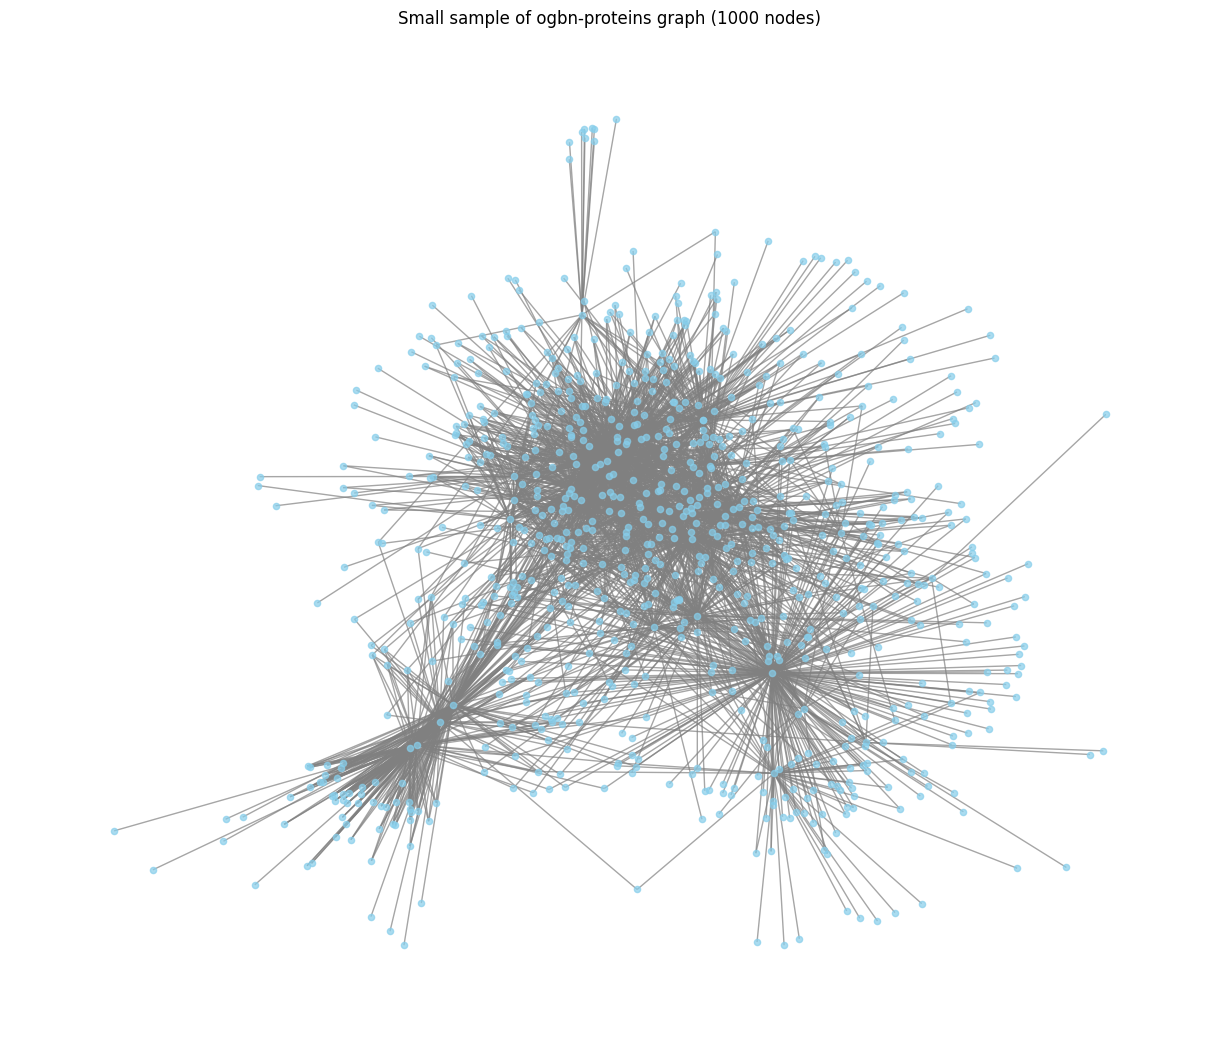

In [26]:
G = nx.Graph()
for row in small_edges.iter_rows():
    src, tgt = row[0], row[1]  # source, target
    G.add_edge(src, tgt)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, iterations=50)
nx.draw(G, pos, node_size=20, node_color="skyblue", edge_color="gray", alpha=0.7)
plt.title("Small sample of ogbn-proteins graph (1000 nodes)")
plt.show()

## ***Average value of edge features (feat_0 to feat_7)***

In [27]:
edges_pl.select([
    pl.col(f"feat_{i}").mean().alias(f"mean_feat_{i}") for i in range(8)
])

mean_feat_0,mean_feat_1,mean_feat_2,mean_feat_3,mean_feat_4,mean_feat_5,mean_feat_6,mean_feat_7
f32,f32,f32,f32,f32,f32,f32,f32
0.098019,0.007893,0.001174,0.004111,0.07386,0.061999,0.031473,0.109963


## ***Number of edges per node (degree distribution)***

In [28]:
degree_dist = edges_pl.group_by("source").agg(
    pl.count().alias("out_degree")
).join(
    edges_pl.group_by("target").agg(
        pl.count().alias("in_degree")
    ),
    left_on="source", right_on="target", how="outer"
).with_columns(
    (pl.col("out_degree").fill_null(0) + pl.col("in_degree").fill_null(0)).alias("total_degree")
)

In [29]:
print("Top 10 nodes with the highest degree:")
print(degree_dist.sort("total_degree", descending=True).head(10))

Top 10 nodes with the highest degree:
shape: (10, 5)
┌────────┬────────────┬────────┬───────────┬──────────────┐
│ source ┆ out_degree ┆ target ┆ in_degree ┆ total_degree │
│ ---    ┆ ---        ┆ ---    ┆ ---       ┆ ---          │
│ i64    ┆ u32        ┆ i64    ┆ u32       ┆ u32          │
╞════════╪════════════╪════════╪═══════════╪══════════════╡
│ 117303 ┆ 7750       ┆ 117303 ┆ 7750      ┆ 15500        │
│ 64506  ┆ 7675       ┆ 64506  ┆ 7675      ┆ 15350        │
│ 64490  ┆ 7526       ┆ 64490  ┆ 7526      ┆ 15052        │
│ 2963   ┆ 6934       ┆ 2963   ┆ 6934      ┆ 13868        │
│ 86886  ┆ 6916       ┆ 86886  ┆ 6916      ┆ 13832        │
│ 63298  ┆ 6758       ┆ 63298  ┆ 6758      ┆ 13516        │
│ 109463 ┆ 6544       ┆ 109463 ┆ 6544      ┆ 13088        │
│ 88587  ┆ 6368       ┆ 88587  ┆ 6368      ┆ 12736        │
│ 32277  ┆ 6292       ┆ 32277  ┆ 6292      ┆ 12584        │
│ 66684  ┆ 6198       ┆ 66684  ┆ 6198      ┆ 12396        │
└────────┴────────────┴────────┴───────────┴───